<h2><font color='Pink'> 8F: Implementing Platt Scaling to find P(Y==1|X)</font></h2>

Check this <a href='https://drive.google.com/open?id=133odBinMOIVb_rh_GQxxsyMRyW-Zts7a'>PDF</a>
<img src='https://i.imgur.com/CAMnVnh.png'>



> 4. Apply SGD algorithm with ($f_{cv}$, $y_{cv}$) and find the weight $W$ intercept $b$ ```Note: here our data is of one dimensional so we will have a one dimensional weight vector i.e W.shape (1,)``` 

> Note1: Don't forget to change the values of $y_{cv}$ as mentioned in the above image. you will calculate y+, y- based on data points in train data

> Note2: the Sklearn's SGD algorithm doesn't support the real valued outputs, you need to use the code that was done in the `'Logistic Regression with SGD and L2'` Assignment after modifying loss function, and use same parameters that used in that assignment.
<img src='https://i.imgur.com/zKYE9Oc.png'>
if Y[i] is 1, it will be replaced with y+ value else it will replaced with y- value

> 5. For a given data point from $X_{test}$, $P(Y=1|X) = \frac{1}{1+exp(-(W*f_{test}+ b))}$ where ` `$f_{test}$ ```= decision_function(```$X_{test}$```)```, W and b will be learned as metioned in the above step

__Note: in the above algorithm, the steps 2, 4 might need hyper parameter tuning, To reduce the complexity of the assignment we are excluding the hyerparameter tuning part, but intrested students can try that__


If any one wants to try other calibration algorithm istonic regression also please check these tutorials

1. http://fa.bianp.net/blog/tag/scikit-learn.html#fn:1

2. https://drive.google.com/open?id=1MzmA7QaP58RDzocB0RBmRiWfl7Co_VJ7

3. https://drive.google.com/open?id=133odBinMOIVb_rh_GQxxsyMRyW-Zts7a

4. https://stat.fandom.com/wiki/Isotonic_regression#Pool_Adjacent_Violators_Algorithm


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import numpy as np
from sklearn.svm import SVC

In [2]:
X, y = make_classification(n_samples=5000, n_features=5, n_redundant=2,
                           n_classes=2, weights=[0.7], class_sep=0.7, random_state=15)

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size=0.8)
x_train, x_cv, y_train, y_cv = train_test_split(x_train,y_train,test_size = 0.25,train_size =0.75)

In [36]:
rbf=SVC(kernel="rbf",C=100,gamma=0.001)
rbf.fit(x_train,y_train)

SVC(C=100, gamma=0.001)

In [37]:
sup_vecs=rbf.support_vectors_  
dual_coefs=rbf.dual_coef_
intercept=rbf.intercept_

In [38]:
#https://stackoverflow.com/questions/28503932/calculating-decision-function-of-svm-manually
def decision_function(x_cv,sup_vecs,intercept,gamma=0.001):
    predict=[]    
    decision=[]
    for xq in x_cv:
        dec_func = 0
        for j in range(len(sup_vecs)):
            norm2 = np.linalg.norm(sup_vecs[j, :] -xq)**2
            dec_func += dual_coefs[0, j] * np.exp(-gamma*norm2) # calculating the sign
        dec_func += intercept
        decision.append(dec_func)
        if (dec_func)<0:               
            predict.append(0)
        else:
            predict.append(1)
    return decision, predict

In [39]:
d_f,f_cv = decision_function(x_cv,sup_vecs,intercept,gamma=0.001)

In [40]:
count_plus = list(y_train).count(1)
count_minus = list(y_train).count(0)
y_plus = (count_plus + 1) / (count_plus + 2)
y_minus = 1 / (count_minus + 2)

In [41]:
#Calculating new Y_CV for calibration
newY_cv = []
for i in y_cv:
    if i == 1:
        newY_cv.append(y_plus)
    else:
        newY_cv.append(y_minus)
newY_cv = np.array(newY_cv)

In [57]:
def initialize_weights(row_vector):
    ''' we will initializing our weights and bias'''
    w=np.zeros_like(row_vector)
    b=0
    return w,b

In [64]:
def sigmoid(w,x,b):
    return 1/(1+np.exp(-(np.dot(x,w.T)+b)))

In [65]:
def gradient_dw(x,y,w,b,alpha,N):
    ''' we will compute the gardient w.r.to w '''
    sigmoid1 = sigmoid(w,x,b)
    dw= ((x*((y-sigmoid1) + b))-((alpha/N)*w))
    return dw

In [66]:
def gradient_db(x,y,w,b):
     '''In this function, we will compute gradient w.r.to b '''
    db=y-sigmoid(w,x,b)
    return db

In [67]:
def logloss(w,x,y,b):
    val=sigmoid(w,x,b)
    return -np.mean(y*np.log10(val)+(1-y)*np.log10(1-val))

In [68]:
from tqdm import tqdm
def train(f_cv,y_cv,epochs,alpha,eta0):
    ''' we will implementing logistic regression from scratch'''
    train_loss = []
    test_loss = []
    w,b = initialize_weights(f_cv[0]) # Initializing the weights
    N = len(f_cv)
    for i in tqdm(range(epochs)):
        test_loss.append(i)
        for j in range(N):
            dw=gradient_dw(f_cv[j], y_cv[j],w,b,alpha,N)
            db=gradient_db(f_cv[j], y_cv[j],w,b)
            w=w+eta0*dw           #updating w, b
            b=b+eta0*db  
        s = logloss(w,f_cv,newY_cv,b)  
        train_loss.append(s)    # storing all the train loss values in a list
    return w,b,test_loss,train_loss

In [69]:
alpha=0.001
eta0=0.001
N=len(x_train)
epochs=45
w,b,test_loss,train_loss=train(d_f,newY_cv,epochs,alpha,eta0)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 28.61it/s]


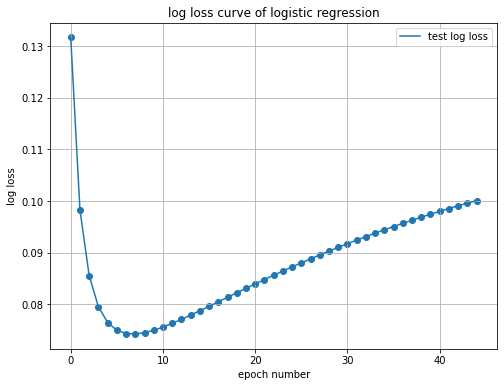

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(test_loss,train_loss, label='test log loss')
plt.scatter(test_loss,train_loss)
plt.title('log loss curve of logistic regression')
plt.xlabel('epoch number')
plt.ylabel("log loss")
plt.legend()

In [92]:
f_test, label = decision_function(x_test, sup_vecs, intercept, gamma = 0.001)

In [93]:
def probability(w, ftest, b):
    x = 1 / (1 + np.exp(-w*f_test + b))
    return x

In [95]:
probab = probability(w, f_test, b)
print(probab[:10])

[[7.22417943e-03]
 [1.48644236e-05]
 [1.17486219e-02]
 [4.52418852e-04]
 [1.08991207e-04]
 [7.76159856e-05]
 [8.82028765e-01]
 [9.99226906e-01]
 [9.92856850e-01]
 [3.40793046e-04]]
